In [1916]:
import pyodbc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [1917]:
# Connect to the Database
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=wd02;"
                        "Database=FootPrint;"
                        "Trusted_Connection=yes;")

# QUERY 01: Operations

In [1918]:
df = pd.read_sql_query("DECLARE @from date, @to date;\
    SELECT\
        @from = getdate()\
        ,@to = dateadd(day, 1, getdate());\
\
SELECT CONVERT(varchar,t.completedDateTime,100) Date, w.name warehouse, p.name project, oc.name operationCode, t.employee\
    FROM datex_footprint.Tasks t\
    JOIN datex_footprint.OperationCodes oc\
        ON oc.id = t.operationCodeId\
    JOIN datex_footprint.Warehouses w\
        ON w.id = t.warehouseId\
    JOIN datex_footprint.Projects p\
        ON p.id = t.projectId\
    WHERE t.completedDateTime >= @from AND t.completedDateTime < @to AND (t.employee != 'FootPrintService') AND (t.employee != 'Foot Print Service') and t.statusId = 2", cnxn)

In [1919]:
# Adding Hours
df['Hour'] = pd.to_datetime(df['Date']).dt.hour
df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Mar 31 2022 6:54AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
1,Mar 31 2022 6:55AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
2,Mar 31 2022 6:55AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
3,Mar 31 2022 6:56AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
4,Mar 31 2022 6:56AM,19,ACG North America LLC,Receiving,Carlos Chavez,6


# WAREHOUSE

In [1920]:
# Group By Warehouse
df_warehouse = df.groupby(['warehouse']).count()[['operationCode']]
df_warehouse.reset_index(inplace=True)
df_warehouse.head()

,warehouse,operationCode
0,10,448
1,12,3
2,16,99
3,17,35
4,18,14


In [1921]:
# Pie Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.pie(activity, labels=warehouse)
#plt.show()

In [1922]:
# Bar Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(warehouse, activity)
#plt.show()

In [1923]:
# Save Data in JSON format
df_warehouse_index = df_warehouse.set_index(['warehouse'])
df_warehouse_index.to_json('data/warehouse.json')
df_warehouse_index.head()

,operationCode
warehouse,
10,448
12,3
16,99
17,35
18,14


### All Operations type

In [1924]:
df_operation = df.groupby(['operationCode']).count()[['project']]
df_operation.reset_index(inplace=True)
df_operation.head()

,operationCode,project
0,Count,55
1,Create Inventory,2
2,DONE RECEIVING,13
3,DRIVER CHECK IN,11
4,Finished Receiving,4


In [1925]:
# Horizontal Bar Chart
values = df_operation['project']
operation = df_operation['operationCode']

#plt.subplots(figsize=(8,8))
#plt.barh(operation, values)
#plt.gca().invert_yaxis()
#plt.show()

In [1926]:
df_operation.rename(columns={"project": "Tasks"})
df_operation.head()

,operationCode,project
0,Count,55
1,Create Inventory,2
2,DONE RECEIVING,13
3,DRIVER CHECK IN,11
4,Finished Receiving,4


In [1927]:
# Save Data in JSON format
df_operation = df_operation.rename(columns={"project": "Tasks"})
df_operation_index = df_operation.set_index(['operationCode'])
df_operation_index.to_json('data/operations_type.json')
df_operation_index.head()

,Tasks
operationCode,
Count,55
Create Inventory,2
DONE RECEIVING,13
DRIVER CHECK IN,11
Finished Receiving,4


### Excluding Operations PICKING and RECEIVING

In [1928]:
df_operation_excluded = df_operation.loc[(df_operation["operationCode"] != 'Picking') &
                                         (df_operation["operationCode"] != 'Receiving')]

In [1929]:
# Save Data in JSON format
df_operation_excluded = df_operation_excluded.rename(columns={"project": "Tasks"})
df_operation_excluded_index = df_operation_excluded.set_index(['operationCode'])
df_operation_excluded_index.to_json('data/operations_type_excluded.json')
df_operation_excluded_index.head()

,Tasks
operationCode,
Count,55
Create Inventory,2
DONE RECEIVING,13
DRIVER CHECK IN,11
Finished Receiving,4


### Operations per Hour

In [1930]:
df_hours = df.groupby(['Hour']).count()[['operationCode']]
df_hours.reset_index(inplace=True)
df_hours.head()

,Hour,operationCode
0,6,42
1,7,125
2,8,393
3,9,323
4,10,49


In [1931]:
# Bar Chart
hour = df_hours['Hour']
activity = df_hours['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(hour, activity)
#plt.xticks(hour)
#plt.show()

In [1932]:
df_hours = df_hours.rename(columns={'operationCode': 'Operations'})
df_hours_index = df_hours.set_index(['Hour'])
df_hours_index.to_json('data/hours.json')
df_hours_index.head()

,Operations
Hour,
6,42
7,125
8,393
9,323
10,49


# PICKING

In [1933]:
# Filtered by Picking
df_picking = df[df['operationCode'] == 'Picking']

In [1934]:
# Grouped by Employee and Hour
df_picking_grouped = df_picking.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_grouped.reset_index(inplace=True)
df_picking_grouped.head()

,employee,Hour,operationCode
0,Aisha Cooper,8,7
1,Aisha Cooper,9,8
2,Aisha Cooper,10,6
3,Andre Nau,9,6
4,Chris Martin,7,1


In [1935]:
# Pivot
df_picking_pivoted = df_picking_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_pivoted = df_picking_pivoted.fillna(0)
df_picking_pivoted = df_picking_pivoted.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

df_picking_pivoted.head()

,7,8,9,10
employee,,,,
Aisha Cooper,0.0,7.0,8.0,6.0
Andre Nau,0.0,0.0,6.0,0.0
Chris Martin,1.0,0.0,0.0,0.0
Edilberto Souza,0.0,0.0,5.0,0.0
Edwin Perez,0.0,3.0,7.0,0.0


### Save in JSON File

In [1936]:
# Save into JSON
pickers = df_picking_pivoted.T
pickers.to_json('data/pickers.json')
pickers.head()

employee,Aisha Cooper,Andre Nau,Chris Martin,Edilberto Souza,Edwin Perez,Ernest Ferguson,Felix Blanco,Frantz Laman,Gonzalo Guzman,Gregory Watts,...,Justin Johnson,Justin Runsdorf,Liliana Puentes,Martha Hurtado,Micah Powers,Sergio Piura,Shawn Saunders,Thalia Rivera,Wayne Gray,Wendy Medrano
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,38.0
8,7.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,3.0,...,6.0,0.0,0.0,0.0,0.0,4.0,13.0,0.0,0.0,37.0
9,8.0,6.0,0.0,5.0,7.0,2.0,1.0,13.0,2.0,5.0,...,0.0,1.0,0.0,0.0,2.0,12.0,24.0,1.0,85.0,10.0
10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


### Picking By Warehouse Function

In [1937]:
# Picking Function
def picking_by_warehouse (warehouse):
    # Filter by warehouse
    df_w = df_picking[df_picking['warehouse'] == warehouse]
    
    # Grouped by Employee and Hour
    df_w_group = df_w.groupby(['employee', 'Hour']).count()[['operationCode']]
    df_w_group.reset_index(inplace=True)
    
    # Pivot
    df_w_pivot = df_w_group.pivot(index='employee', columns='Hour', values='operationCode')
    df_w_pivot = df_w_pivot.fillna(0)
    df_w_pivot = df_w_pivot.rename_axis(None, axis=1)
    
    # Save into JSON
    pickers_df = df_w_pivot.T
    file_name = f'data/pickers_w{warehouse}.json'
    pickers_df.to_json(file_name)

In [1938]:
# Save warehouse data into JSON files
picking_by_warehouse('10')
picking_by_warehouse('12')
picking_by_warehouse('15')
picking_by_warehouse('16')
picking_by_warehouse('18')
picking_by_warehouse('19')
picking_by_warehouse('20')
picking_by_warehouse('21')
picking_by_warehouse('22')

# RECEIVING

In [1939]:
# Filtered by Picking
receiving_df = df[df['operationCode'] == 'Receiving']
receiving_df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Mar 31 2022 6:54AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
1,Mar 31 2022 6:55AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
2,Mar 31 2022 6:55AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
3,Mar 31 2022 6:56AM,19,ACG North America LLC,Receiving,Carlos Chavez,6
4,Mar 31 2022 6:56AM,19,ACG North America LLC,Receiving,Carlos Chavez,6


In [1940]:
# Grouped by Employee and Hour
receiving_group_df = receiving_df.groupby(['employee', 'Hour']).count()[['operationCode']]
receiving_group_df.reset_index(inplace=True)
receiving_group_df.head()

,employee,Hour,operationCode
0,Carlos Chavez,6,25
1,Felix Blanco,8,23
2,Juan Castro,7,38
3,Juan Castro,9,1
4,Juan Castro,10,2


In [1941]:
# Pivot
receiving_pivot_df = receiving_group_df.pivot(index='employee', columns='Hour', values='operationCode')
receiving_pivot_df = receiving_pivot_df.fillna(0)
receiving_pivot_df = receiving_pivot_df.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

receiving_pivot_df.head()

,6,7,8,9,10
employee,,,,,
Carlos Chavez,25.0,0.0,0.0,0.0,0.0
Felix Blanco,0.0,0.0,23.0,0.0,0.0
Juan Castro,0.0,38.0,0.0,1.0,2.0
Justin Runsdorf,0.0,0.0,0.0,2.0,0.0
Luci Nicley,0.0,0.0,0.0,7.0,0.0


In [1942]:
# Save into JSON
receivers = receiving_pivot_df.T
receivers.to_json('data/receivers.json')
receivers.head()

employee,Carlos Chavez,Felix Blanco,Juan Castro,Justin Runsdorf,Luci Nicley,Marzetta Bracken,Sandra Vega,Thalia Rivera,Yulieth Aguirre
6,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,23.0,0.0,0.0,0.0,17.0,6.0,134.0,0.0
9,0.0,0.0,1.0,2.0,7.0,0.0,20.0,0.0,1.0
10,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


# INVENTORY

In [1943]:
# Group By Operation Code and Warehouse
cycle_count_df = df.groupby(['operationCode', 'warehouse']).count()[['employee']]
cycle_count_df.reset_index(inplace=True)

In [1944]:
# Filtering by Count, Recount and Inventory Adjustment
cc_df = cycle_count_df.loc[(cycle_count_df["operationCode"] == 'Count') |
                           (cycle_count_df["operationCode"] == 'Recount') |
                           (cycle_count_df["operationCode"] == 'Inventory Adjustment')]

cc_df = cc_df.rename(columns={'employee': 'count'})

In [1945]:
cc_df_pivot = cc_df.pivot(index='operationCode', columns='warehouse', values='count')

In [1946]:
try:
    cc_df_pivot.rename({'Count': 'Inventory Counts'}, axis='index', inplace=True)
except:
    print('Operation COUNT does not exist yet')
    
try:
    cc_df_pivot.rename({'Recount': 'Discrepancies'}, axis='index', inplace=True)
except:
    print('Operation DISCREPANCIES does not exist yet')
    
try:
    cc_df_pivot.rename({'Inventory Adjustment': 'Inventory Adjustments'}, axis='index', inplace=True)
except:
    print('Operation INVENTORY ADJUSTMENT does not exist yet')

In [1947]:
cc_df_pivot = cc_df_pivot.fillna(0)
cc_df_pivot.to_json('data/cycle_count.json')
cc_df_pivot.head()

warehouse,10,19,20
operationCode,,,
Inventory Counts,27.0,7.0,21.0
Inventory Adjustments,1.0,0.0,1.0
Discrepancies,0.0,0.0,1.0


# QUERY 02: Open Outbounds

In [1948]:
df_02 = pd.read_sql_query("SELECT DISTINCT w.name warehouse, p.name project, s.lookupCode shipment_number, s.createdSysDateTime\
    FROM datex_footprint.shipments s\
    LEFT JOIN datex_footprint.ShipmentOrderLookup sol\
        on sol.shipmentId = s.id\
    LEFT JOIN datex_footprint.orders o\
        on o.id = sol.orderId\
    LEFT JOIN datex_footprint.Projects p\
        on p.id = o.projectId\
    LEFT JOIN datex_footprint.warehouses w\
        on w.id = isnull(s.actualWarehouseId, s.expectedWarehouseId)\
    WHERE s.statusId in (1, 2, 4) and s.typeId = 2\
    ORDER BY createdSysDateTime", cnxn)

In [1949]:
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447


In [1950]:
df_02['age_order'] = pd.Timestamp.now() - df_02['createdSysDateTime']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1709 days 01:10:50.673243
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,912 days 23:29:49.727243
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,867 days 17:43:15.077243
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,798 days 20:59:46.807243
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,798 days 20:59:46.423243


In [1951]:
df_02['age_order_days'] = df_02['age_order'].dt.components['days']
df_02['age_order_hours'] = df_02['age_order'].dt.components['hours']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order,age_order_days,age_order_hours
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1709 days 01:10:50.673243,1709,1
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,912 days 23:29:49.727243,912,23
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,867 days 17:43:15.077243,867,17
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,798 days 20:59:46.807243,798,20
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,798 days 20:59:46.423243,798,20


In [1952]:
bins =[-1,1,2,3,7,30,60, 90,365, 730,10000]
bin_names = ['24 Hours', '48 Hours', '72 Hours', '1 Week', '1 Month', '2 Months', '3 Months', '1 Year', '2 Years', 'More than 2 years']

df_02['age_group'] = pd.cut(df_02['age_order_days'], bins, labels=bin_names)

In [1953]:
df_02_grouped = df_02.groupby(['age_group'])[['project']].count()

In [1954]:
df_02_grouped = df_02_grouped.rename(columns={'project': 'orders'})

In [1955]:
df_02_grouped

,orders
age_group,
24 Hours,863
48 Hours,240
72 Hours,94
1 Week,270
1 Month,938
2 Months,640
3 Months,634
1 Year,2211
2 Years,1003


### Save in JSON File

In [1956]:
open_outbounds = df_02_grouped
open_outbounds.to_json('data/open_outbounds.json')
open_outbounds

,orders
age_group,
24 Hours,863
48 Hours,240
72 Hours,94
1 Week,270
1 Month,938
2 Months,640
3 Months,634
1 Year,2211
2 Years,1003


<AxesSubplot:ylabel='age_group'>

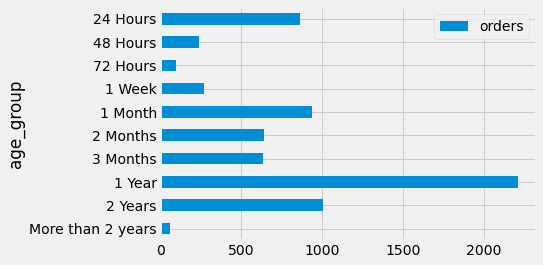

In [1957]:
df_02_grouped = df_02_grouped.iloc[::-1]
df_02_grouped.plot.barh()

In [1958]:
# Close connection
cnxn.close()